In [1]:
# Cell 1: imports & settings
%matplotlib inline
import random
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

random.seed(42)


In [2]:
# Cell 2: simple data containers
class Patient:
    def __init__(self, pid, severity, arrival_time):
        """
        severity: integer 1..10 (10 = most critical)
        arrival_time: simulation step or datetime
        """
        self.id = pid
        self.severity = severity
        self.arrival_time = arrival_time
        self.allocated_bed = None
        self.wait_time = 0  # increments each step patient is not allocated

class Bed:
    def __init__(self, bid, location):
        """
        location: (row, col) coordinates for visualization / distance
        occupied: whether bed currently occupied
        """
        self.id = bid
        self.location = location
        self.occupied = False
        self.patient = None


In [3]:
# Cell 3: hospital environment
class HospitalEnvironment:
    def __init__(self, rows=3, cols=4):
        """
        Create a grid of bed locations: rows x cols
        Maintain:
          - beds dict: bed_id -> Bed
          - waiting_queue: list of Patient (FIFO order, new arrivals appended)
          - time_step (integer simulation step)
        """
        self.rows = rows
        self.cols = cols
        self.beds = {}
        bid = 0
        for r in range(rows):
            for c in range(cols):
                self.beds[bid] = Bed(bid, (r, c))
                bid += 1

        self.waiting_queue = []
        self.time_step = 0
        self.next_patient_id = 1

    def step_time(self):
        self.time_step += 1
        # increment wait time for queued patients
        for p in self.waiting_queue:
            p.wait_time += 1

    def create_random_arrivals(self, p_prob=0.4):
        """Randomly create 0 or few new patients this step."""
        if random.random() < p_prob:
            # generate 1-2 patients
            for _ in range(random.choice([1, 1])):
                severity = random.randint(1, 10)
                p = Patient(self.next_patient_id, severity, self.time_step)
                self.next_patient_id += 1
                self.waiting_queue.append(p)

    def free_bed(self, bed_id):
        """Free a bed (discharge)"""
        bed = self.beds.get(bed_id)
        if bed and bed.occupied:
            bed.occupied = False
            bed.patient = None

    def occupy_bed(self, bed_id, patient):
        bed = self.beds.get(bed_id)
        if bed and not bed.occupied:
            bed.occupied = True
            bed.patient = patient
            patient.allocated_bed = bed_id
            # remove patient from waiting queue if present
            self.waiting_queue = [q for q in self.waiting_queue if q.id != patient.id]
            return True
        return False

    def get_free_beds(self):
        return [b for b in self.beds.values() if not b.occupied]


In [4]:
# Cell 4: utility function + agent
def compute_utility(patient, bed, current_time, distance_weight=1.0, wait_weight=0.5):
    """
    Utility = benefit_from_allocating - cost
    benefit_from_allocating ~ severity (higher severity => higher benefit)
    costs:
      - distance cost: Manhattan distance from some central triage (0,0) to bed location
      - waiting cost: small penalty for waiting time (we can add penalty to utility if want to prefer earlier)
    Return a numeric utility (higher is better).
    """
    # severity benefit
    benefit = patient.severity * 10.0  # scale severity

    # distance cost (use Manhattan distance to triage (0,0))
    triage_location = (0, 0)
    bed_loc = bed.location
    dist = abs(bed_loc[0] - triage_location[0]) + abs(bed_loc[1] - triage_location[1])
    distance_cost = distance_weight * dist * 2.0  # scaling

    # waiting penalty grows with wait_time
    wait_cost = wait_weight * patient.wait_time * 1.5

    utility = benefit - (distance_cost + wait_cost)
    return utility

class UtilityBasedBedAllocator:
    def __init__(self, distance_weight=1.0, wait_weight=0.5):
        self.distance_weight = distance_weight
        self.wait_weight = wait_weight

    def allocate(self, env):
        """
        Try to allocate waiting patients to best available beds to maximize utility.
        Strategy (greedy):
          - For each patient (ordered by severity desc or arrival), compute best bed utility;
          - allocate the patient-bed pair with the highest utility if positive.
          - repeat until no free beds or no positive utility pairs.
        """
        allocations = []
        free_beds = env.get_free_beds()
        if not free_beds or not env.waiting_queue:
            return allocations

        # we'll consider all patient-bed pairs
        candidates = []
        for patient in env.waiting_queue:
            for bed in free_beds:
                util = compute_utility(patient, bed, env.time_step,
                                       distance_weight=self.distance_weight,
                                       wait_weight=self.wait_weight)
                candidates.append((util, patient, bed))

        # sort candidates by utility descending
        candidates.sort(key=lambda x: x[0], reverse=True)

        used_beds = set()
        used_patients = set()
        for util, patient, bed in candidates:
            if util <= 0:
                # don't allocate if utility non-positive
                continue
            if bed.id in used_beds or patient.id in used_patients:
                continue
            # allocate
            success = env.occupy_bed(bed.id, patient)
            if success:
                allocations.append((patient.id, bed.id, util))
                used_beds.add(bed.id)
                used_patients.add(patient.id)
        return allocations


In [5]:
# Cell 5: visualization
def draw_hospital(env, step_num=None, title_extra=""):
    clear_output(wait=True)
    rows, cols = env.rows, env.cols
    grid = np.zeros((rows, cols))

    # code: 0 = free bed, 1 = occupied bed
    for b in env.beds.values():
        r, c = b.location
        grid[r, c] = 1 if b.occupied else 0

    plt.figure(figsize=(cols*1.5, rows*1.2))
    plt.imshow(grid, cmap='Pastel1', vmin=0, vmax=1)
    plt.title(f"Hospital Beds | Step {env.time_step} {title_extra}")
    plt.axis('off')

    # annotate each bed with id and patient/severity
    for b in env.beds.values():
        r, c = b.location
        text = f"Bed {b.id}\n"
        if b.occupied:
            text += f"P{b.patient.id} S{b.patient.severity}"
        else:
            text += "Free"
        plt.text(c, r, text, ha='center', va='center', fontsize=8, color='black')

    # show waiting queue below
    plt.show()

    # print queue
    print("Waiting Queue (front -> end):")
    if not env.waiting_queue:
        print("  [empty]")
    else:
        for p in env.waiting_queue:
            print(f"  P{p.id} | Sev:{p.severity} | Wait:{p.wait_time}")


In [6]:
# Cell 6: one simulation step
def sim_step(env, allocator, arrival_prob=0.5, discharge_prob=0.05):
    """
    1. New random patient arrivals
    2. Optionally discharge some occupied beds with small probability (simulate turnover)
    3. Allocator tries to assign waiting patients to beds
    4. Advance time
    """
    # random arrivals
    env.create_random_arrivals(p_prob=arrival_prob)

    # random discharge: some occupied beds become free
    for bed in list(env.beds.values()):
        if bed.occupied and (random.random() < discharge_prob):
            env.free_bed(bed.id)

    # allocator attempts allocation
    allocations = allocator.allocate(env)

    # advance simulation clock (updates wait times)
    env.step_time()

    return allocations


In [7]:
# Cell 7: run a demo simulation
def run_demo(steps=20, rows=3, cols=4, arrival_prob=0.5, discharge_prob=0.05,
             distance_weight=1.0, wait_weight=0.6, delay=0.6):
    env = HospitalEnvironment(rows=rows, cols=cols)
    allocator = UtilityBasedBedAllocator(distance_weight=distance_weight, wait_weight=wait_weight)

    for s in range(1, steps+1):
        allocations = sim_step(env, allocator, arrival_prob, discharge_prob)
        title_extra = f"| Allocated: {len(allocations)}"
        draw_hospital(env, step_num=s, title_extra=title_extra)
        if allocations:
            print("Allocations made (patient_id -> bed_id) with utility:")
            for pid, bid, util in allocations:
                print(f"  P{pid} -> Bed{bid}  util={util:.1f}")
        time.sleep(delay)
    print("Demo finished.")

# Example run:
# run_demo(steps=25, rows=3, cols=4, arrival_prob=0.6, discharge_prob=0.08, delay=0.6)


In [8]:
# Cell 8: optional comparison with naive FIFO allocator
class FIFOAllocator:
    def allocate(self, env):
        allocations = []
        free_beds = env.get_free_beds()
        while free_beds and env.waiting_queue:
            bed = free_beds.pop(0)
            patient = env.waiting_queue.pop(0)
            env.occupy_bed(bed.id, patient)
            allocations.append((patient.id, bed.id))
        return allocations

def compare_allocators(steps=20):
    # run two parallel envs with same arrivals by seeding randomness differently
    env1 = HospitalEnvironment(rows=3, cols=4)
    env2 = HospitalEnvironment(rows=3, cols=4)
    alloc1 = UtilityBasedBedAllocator()
    alloc2 = FIFOAllocator()

    total_alloc1 = 0
    total_alloc2 = 0
    # To get same arrivals: generate arrivals list then feed to both envs
    arrivals_log = []
    random.seed(123)
    for _ in range(steps):
        # decide whether arrival occurs and severity
        if random.random() < 0.5:
            arrivals_log.append(random.randint(1,10))
        else:
            arrivals_log.append(None)

    # replay arrivals
    for s in range(steps):
        sev = arrivals_log[s]
        if sev is not None:
            p1 = Patient(env1.next_patient_id, sev, env1.time_step)
            env1.next_patient_id += 1
            env1.waiting_queue.append(p1)
            p2 = Patient(env2.next_patient_id, sev, env2.time_step)
            env2.next_patient_id += 1
            env2.waiting_queue.append(p2)

        # run allocators
        allocs1 = alloc1.allocate(env1)
        allocs2 = alloc2.allocate(env2)
        total_alloc1 += len(allocs1)
        total_alloc2 += len(allocs2)

        # advance time and possibly discharge some beds
        env1.step_time(); env2.step_time()
    print(f"Total allocations: utility-based={total_alloc1}, FIFO={total_alloc2}")

# compare_allocators(steps=30)


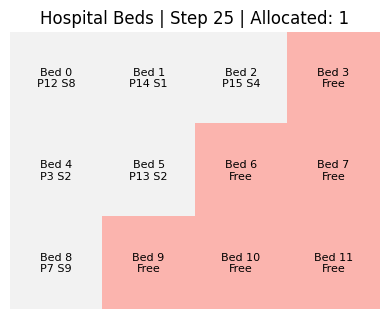

Waiting Queue (front -> end):
  [empty]
Allocations made (patient_id -> bed_id) with utility:
  P15 -> Bed2  util=36.0
Demo finished.


In [9]:
run_demo(steps=25, rows=3, cols=4, arrival_prob=0.6, discharge_prob=0.08, delay=0.5)
